In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import urllib.request as req
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
import urllib.parse
from bs4 import BeautifulSoup
import requests
from selenium import webdriver

# 셀프 주유소는 과연 저렴한가?

+ 실제 셀프 주유소가 저렴한지에 대한 팩트 체크
+ 가장 싼 주유소는 어디인가?
+ http://www.opinet.co.kr

### 1. 서울시 구별 주유소 가격 정보 가져오기

#### 1) Sample Code 

In [2]:
##### 원격 제어창 실행

driver = webdriver.Chrome("C:/netsong7/download/chromedriver_win32/chromedriver")
driver.get("https://www.opinet.co.kr/searRgSelect.do")

In [10]:
##### 시 목록 가져오기

si_list_raw = driver.find_element_by_xpath("""//*[@id="SIDO_NM0"]""")
si_list = si_list_raw.find_elements_by_tag_name("option")
si_list
si_list[1].get_attribute("value")

si_names = [option.get_attribute("value") for option in si_list]
si_names.remove("")
si_names

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

In [16]:
##### 시 선택하기

element = driver.find_element_by_id("SIDO_NM0")
element.send_keys(si_names[0])

In [24]:
##### 구 목록 가져오기

gu_list_raw = driver.find_element_by_xpath("""//*[@id="SIGUNGU_NM0"]""")
gu_list = gu_list_raw.find_elements_by_tag_name("option")
gu_list
gu_list[1].get_attribute("value")

gu_names = [option.get_attribute("value") for option in gu_list]
gu_names.remove("")
gu_names

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [28]:
##### 구 선택하기

element = driver.find_element_by_id("SIGUNGU_NM0")
element.send_keys(gu_names[5])

In [ ]:
##### 조회 버튼 누르기

search = """//*[@id="searRgSelect"]/span"""
driver.find_element_by_xpath(search).click()

In [29]:
##### 엑셀 저장버튼 누르기

excel = """//*[@id="glopopd_excel"]/span"""
driver.find_element_by_xpath(excel).click()

#### 2) 지역별(구 별)로 주유소 정보를 엑셀파일로 저장

In [31]:
from tqdm import tqdm_notebook
import time

In [32]:
for gu in tqdm_notebook(gu_names):
    element = driver.find_element_by_id("SIGUNGU_NM0")
    element.send_keys(gu)
    
    time.sleep(1)
    
    search = """//*[@id="searRgSelect"]/span"""
    driver.find_element_by_xpath(search).click()
    
    time.sleep(1)
    
    excel = """//*[@id="glopopd_excel"]/span"""
    driver.find_element_by_xpath(excel).click()
    
    time.sleep(1)
    
driver.close()

### 2. Data Preprocessing

#### 1) 저장된 엑셀 파일 불러오기

In [2]:
from glob import glob

In [3]:
station_files = glob("data/oil/지역*.xls")
station_files

tmp_raw = []
for fname in station_files:
    tmp = pd.read_excel(fname, header=2)
    tmp_raw.append(tmp)

In [4]:
len(tmp_raw)

25

In [5]:
##### 데이터 프레임으로 합치기

station_raw = pd.concat(tmp_raw)
station_raw.head()
station_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 38
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지역      486 non-null    object
 1   상호      486 non-null    object
 2   주소      486 non-null    object
 3   상표      486 non-null    object
 4   전화번호    486 non-null    object
 5   셀프여부    486 non-null    object
 6   고급휘발유   486 non-null    object
 7   휘발유     486 non-null    object
 8   경유      486 non-null    object
 9   실내등유    486 non-null    object
dtypes: object(10)
memory usage: 41.8+ KB


In [6]:
stations = pd.DataFrame({"Oil_store":station_raw["상호"],
             "주소":station_raw["주소"],
             "가격":station_raw["휘발유"],
             "셀프":station_raw["셀프여부"],
             "상표":station_raw["상표"]})

stations.head()

,Oil_store,주소,가격,셀프,상표
0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1549,Y,현대오일뱅크
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1603,N,현대오일뱅크
2,지에스칼텍스㈜ 동서울주유소,서울 강동구 천호대로 1456 (상일동),1635,Y,GS칼텍스
3,현대오일뱅크㈜직영 명일셀프주유소,서울 강동구 고덕로 168 (명일동),1635,Y,현대오일뱅크
4,대성석유(주)직영 길동주유소,서울 강동구 천호대로 1168,1638,N,GS칼텍스


In [7]:
##### 구 컬럼 추출

stations["구"] = [addr.split()[1] for addr in stations["주소"]]
stations.head()

,Oil_store,주소,가격,셀프,상표,구
0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1549,Y,현대오일뱅크,강동구
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1603,N,현대오일뱅크,강동구
2,지에스칼텍스㈜ 동서울주유소,서울 강동구 천호대로 1456 (상일동),1635,Y,GS칼텍스,강동구
3,현대오일뱅크㈜직영 명일셀프주유소,서울 강동구 고덕로 168 (명일동),1635,Y,현대오일뱅크,강동구
4,대성석유(주)직영 길동주유소,서울 강동구 천호대로 1168,1638,N,GS칼텍스,강동구


In [8]:
print(stations["구"].unique())
print(len(stations["구"].unique()))

['강동구' '동대문구' '동작구' '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구'
 '강북구' '용산구' '은평구' '종로구' '중구' '중랑구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구'
 '도봉구' '강남구']
25


In [9]:
# 가격이 없는 주유소는 제외

stations["가격"].unique()

stations[stations["가격"] == "-"]

stations = stations[stations["가격"] != "-"]

In [10]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 0 to 36
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Oil_store  474 non-null    object
 1   주소         474 non-null    object
 2   가격         474 non-null    object
 3   셀프         474 non-null    object
 4   상표         474 non-null    object
 5   구          474 non-null    object
dtypes: object(6)
memory usage: 25.9+ KB


In [11]:
# 가격 정보를 수치로 변환

stations["가격"] = [float(val) for val in stations["가격"]]
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 0 to 36
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Oil_store  474 non-null    object 
 1   주소         474 non-null    object 
 2   가격         474 non-null    float64
 3   셀프         474 non-null    object 
 4   상표         474 non-null    object 
 5   구          474 non-null    object 
dtypes: float64(1), object(5)
memory usage: 25.9+ KB


In [12]:
stations.head()

,Oil_store,주소,가격,셀프,상표,구
0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1549.0,Y,현대오일뱅크,강동구
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1603.0,N,현대오일뱅크,강동구
2,지에스칼텍스㈜ 동서울주유소,서울 강동구 천호대로 1456 (상일동),1635.0,Y,GS칼텍스,강동구
3,현대오일뱅크㈜직영 명일셀프주유소,서울 강동구 고덕로 168 (명일동),1635.0,Y,현대오일뱅크,강동구
4,대성석유(주)직영 길동주유소,서울 강동구 천호대로 1168,1638.0,N,GS칼텍스,강동구


In [13]:
##### 인덱스 조정

stations.reset_index(inplace=True)

In [14]:
stations

,index,Oil_store,주소,가격,셀프,상표,구
0,0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1549.0,Y,현대오일뱅크,강동구
1,1,구천면주유소,서울 강동구 구천면로 357 (암사동),1603.0,N,현대오일뱅크,강동구
2,2,지에스칼텍스㈜ 동서울주유소,서울 강동구 천호대로 1456 (상일동),1635.0,Y,GS칼텍스,강동구
3,3,현대오일뱅크㈜직영 명일셀프주유소,서울 강동구 고덕로 168 (명일동),1635.0,Y,현대오일뱅크,강동구
4,4,대성석유(주)직영 길동주유소,서울 강동구 천호대로 1168,1638.0,N,GS칼텍스,강동구
...,...,...,...,...,...,...,...
469,32,경원주유소,서울 강남구 도산대로 428 (청담동),2056.0,N,S-OIL,강남구
470,33,(주)소모에너지엔테크놀러지 쎈트럴주유소,서울 강남구 삼성로 335,2068.0,N,GS칼텍스,강남구
471,34,학여울주유소,서울 강남구 남부순환로 3170 (일원2동),2069.0,N,GS칼텍스,강남구
472,35,(주)만정에너지,서울 강남구 봉은사로 433 (삼성동),2113.0,N,GS칼텍스,강남구


In [15]:
del stations["index"]

In [16]:
stations

,Oil_store,주소,가격,셀프,상표,구
0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1549.0,Y,현대오일뱅크,강동구
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1603.0,N,현대오일뱅크,강동구
2,지에스칼텍스㈜ 동서울주유소,서울 강동구 천호대로 1456 (상일동),1635.0,Y,GS칼텍스,강동구
3,현대오일뱅크㈜직영 명일셀프주유소,서울 강동구 고덕로 168 (명일동),1635.0,Y,현대오일뱅크,강동구
4,대성석유(주)직영 길동주유소,서울 강동구 천호대로 1168,1638.0,N,GS칼텍스,강동구
...,...,...,...,...,...,...
469,경원주유소,서울 강남구 도산대로 428 (청담동),2056.0,N,S-OIL,강남구
470,(주)소모에너지엔테크놀러지 쎈트럴주유소,서울 강남구 삼성로 335,2068.0,N,GS칼텍스,강남구
471,학여울주유소,서울 강남구 남부순환로 3170 (일원2동),2069.0,N,GS칼텍스,강남구
472,(주)만정에너지,서울 강남구 봉은사로 433 (삼성동),2113.0,N,GS칼텍스,강남구


### 3. EDA

#### 1) 셀프 여부에 따른 가격 차이

<AxesSubplot:title={'center':'가격'}, xlabel='셀프'>

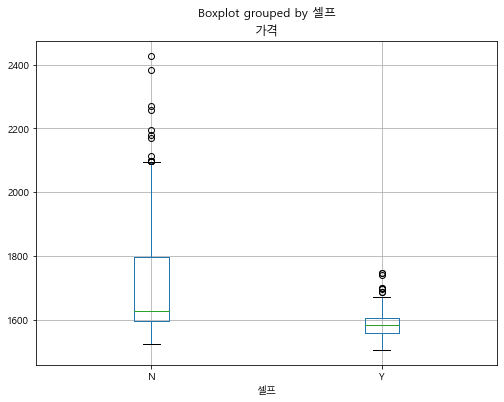

In [18]:
stations.boxplot(by="셀프", column="가격", figsize=(8, 6))

#### 2) 주유소의 상표별로 얼마나 저렴한가?

<AxesSubplot:xlabel='상표', ylabel='가격'>

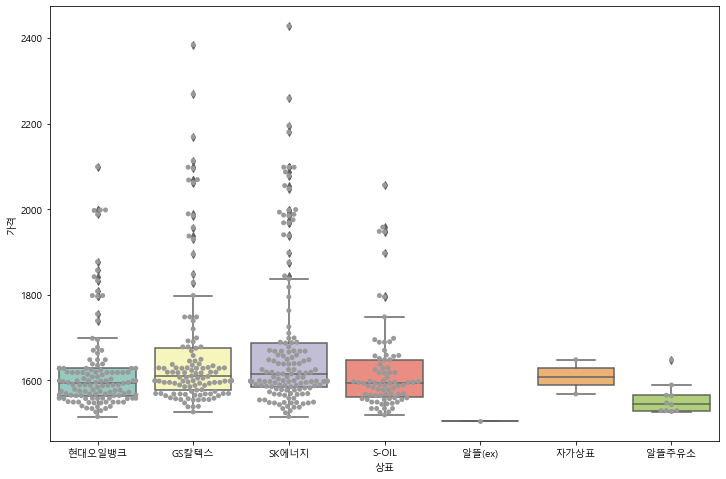

In [30]:
plt.figure(figsize=(12, 8))
sns.boxplot(x = "상표", y = "가격", data=stations, palette="Set3")
sns.swarmplot(x = "상표", y = "가격", data=stations, color=".6")

#### 3) 구별 주유 가격 확인

In [31]:
##### 서울시에서 가장 주유 가격이 비싼 곳은 어디인가?(10개만 확인)

stations.sort_values(by="가격", ascending=False).head(10)

,Oil_store,주소,가격,셀프,상표,구
294,서남주유소,서울 중구 통일로 30,2428.0,N,SK에너지,중구
259,서계주유소,서울 용산구 청파로 367 (서계동),2384.0,N,GS칼텍스,용산구
293,필동주유소,서울 중구 퇴계로 196 (필동2가),2269.0,N,GS칼텍스,중구
292,SK에너지(주) 퇴계로주유소,서울 중구 퇴계로 228 (필동2가),2259.0,N,SK에너지,중구
473,뉴서울(강남),서울 강남구 언주로 716,2195.0,N,SK에너지,강남구
258,동자동주유소,서울 용산구 한강대로104길 6 (동자동),2180.0,N,SK에너지,용산구
291,약수주유소,서울 중구 다산로 173,2169.0,N,GS칼텍스,중구
472,(주)만정에너지,서울 강남구 봉은사로 433 (삼성동),2113.0,N,GS칼텍스,강남구
233,현대오일뱅크㈜직영 여의도현대주유소,서울 영등포구 의사당대로 154 (여의도동),2099.0,N,현대오일뱅크,영등포구
283,(주)대양씨앤씨 사직주유소,서울 종로구 사직로 65 (사직동),2098.0,N,GS칼텍스,종로구


In [32]:
##### 서울시에서 가장 주유 가격이 싼 곳은 어디인가?(10개만 확인)

stations.sort_values(by="가격").head(10)

,Oil_store,주소,가격,셀프,상표,구
73,만남의광장주유소,서울 서초구 양재대로12길 73-71,1504.0,Y,알뜰(ex),서초구
207,영등포제일셀프주유소,서울 영등포구 가마산로 379,1515.0,Y,현대오일뱅크,영등포구
208,남서울고속주유소,서울 영등포구 가마산로 367 (대림동),1515.0,Y,SK에너지,영등포구
209,성락주유소,서울 영등포구 가마산로 414 (신길동),1519.0,Y,S-OIL,영등포구
181,가로공원주유소,서울 양천구 가로공원로 165 (신월동),1524.0,N,SK에너지,양천구
182,현대주유소,서울 양천구 남부순환로 372 (신월동),1525.0,Y,S-OIL,양천구
234,(주)석산에너지,서울 강북구 삼양로 316 (수유동),1526.0,Y,현대오일뱅크,강북구
235,북서울고속주유소,서울 강북구 삼양로 410 (수유동),1526.0,Y,S-OIL,강북구
236,수유동주유소,서울 강북구 도봉로 395 (수유동),1526.0,Y,GS칼텍스,강북구
125,원천주유소,서울 성북구 돌곶이로 142 (장위동),1527.0,N,알뜰주유소,성북구


In [33]:
##### 구별로 평균값 산출

gu_mean = pd.pivot_table(stations, index=["구"], values=["가격"])
gu_mean.head()

,가격
구,
강남구,1791.270270
강동구,1682.437500
강북구,1548.153846
강서구,1598.696970
관악구,1626.687500


In [39]:
##### 위의 구별 평균값을 지도로 표시

import folium
import json

map = folium.Map(location=[37.497911, 127.027558], zoom_start=10)

geo_path = "data/skorea_municipalities_geo_simple_seoul.json"
geo_enc = json.load(open(geo_path, encoding="utf-8"))

map.choropleth(geo_data=geo_enc, data=gu_mean, key_on="feature.id",
              columns=[gu_mean.index, "가격"], fill_color="YlGn")

map

#### 4) 주유 가격 상하위 10씩을 지도에 표시

In [40]:
oil_price_top10 = stations.sort_values(by="가격", ascending=False).head(10)
oil_price_bottom10 = stations.sort_values(by="가격", ascending=True).head(10)

In [43]:
##### 샘플 코드

import requests

header = {"Authorization":"KakaoAK 2fc60a429733da6fb3c988d4924ec63b"}
url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format("서울 용산구 청파로 367")

#requests.get(url, headers=header).json()["documents"][0]["address_name"]

type(requests.get(url, headers=header).json())
requests.get(url, headers=header).json()

{'documents': [{'address_name': '서울 용산구 서계동 47-15',
   'category_group_code': 'OL7',
   'category_group_name': '주유소,충전소',
   'category_name': '교통,수송 > 자동차 > 주유,가스 > 주유소 > GS칼텍스',
   'distance': '',
   'id': '7936627',
   'phone': '02-706-6485',
   'place_name': '서계주유소',
   'place_url': 'http://place.map.kakao.com/7936627',
   'road_address_name': '서울 용산구 청파로 367',
   'x': '126.968973680782',
   'y': '37.552339430427'}],
 'meta': {'is_end': True,
  'pageable_count': 1,
  'same_name': {'keyword': '', 'region': [], 'selected_region': '서울 용산구 청파로'},
  'total_count': 1}}

In [52]:
print(oil_price_top10["주소"])
print("--------------------------------------------")
oil_price_top10["주소"][259]

294                서울 중구 통일로 30
259        서울 용산구 청파로 367 (서계동)
293       서울 중구  퇴계로 196 (필동2가)
292        서울 중구 퇴계로 228 (필동2가)
473              서울 강남구 언주로 716
258     서울 용산구 한강대로104길 6 (동자동)
291               서울 중구 다산로 173
472       서울 강남구 봉은사로 433 (삼성동)
233    서울 영등포구 의사당대로 154 (여의도동)
283         서울 종로구 사직로 65 (사직동)
Name: 주소, dtype: object
--------------------------------------------


'서울 용산구 청파로 367 (서계동)'

In [53]:
[addr.split(" (")[0:1] for addr in oil_price_top10["주소"]]

[['서울 중구 통일로 30'],
 ['서울 용산구 청파로 367'],
 ['서울 중구  퇴계로 196'],
 ['서울 중구 퇴계로 228'],
 ['서울 강남구 언주로 716'],
 ['서울 용산구 한강대로104길 6'],
 ['서울 중구 다산로 173'],
 ['서울 강남구 봉은사로 433'],
 ['서울 영등포구 의사당대로 154'],
 ['서울 종로구 사직로 65']]

In [60]:
lat = []
lng = []

for n in oil_price_top10.index:
    tmp_addr = str(oil_price_top10["주소"][n]).split("(")[0]
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(tmp_addr)
    
    lng.append(requests.get(url, headers=header).json()["documents"][0]["x"])
    lat.append(requests.get(url, headers=header).json()["documents"][0]["y"])   

In [64]:
oil_price_top10["lat"] = lat
oil_price_top10["lng"] = lng

oil_price_top10.head()

,Oil_store,주소,가격,셀프,상표,구,lat,lng
294,서남주유소,서울 중구 통일로 30,2428.0,N,SK에너지,중구,37.5583624710728,126.972067727197
259,서계주유소,서울 용산구 청파로 367 (서계동),2384.0,N,GS칼텍스,용산구,37.552339430427,126.968973680782
293,필동주유소,서울 중구 퇴계로 196 (필동2가),2269.0,N,GS칼텍스,중구,37.5608920015614,126.993679939796
292,SK에너지(주) 퇴계로주유소,서울 중구 퇴계로 228 (필동2가),2259.0,N,SK에너지,중구,37.5617318652342,126.997147791816
473,뉴서울(강남),서울 강남구 언주로 716,2195.0,N,SK에너지,강남구,37.5176495710055,127.035735685446


In [65]:
lat = []
lng = []

for n in oil_price_bottom10.index:
    tmp_addr = str(oil_price_bottom10["주소"][n]).split("(")[0]
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(tmp_addr)
    
    lng.append(requests.get(url, headers=header).json()["documents"][0]["x"])
    lat.append(requests.get(url, headers=header).json()["documents"][0]["y"])   

In [66]:
oil_price_bottom10["lat"] = lat
oil_price_bottom10["lng"] = lng

oil_price_bottom10.head()

,Oil_store,주소,가격,셀프,상표,구,lat,lng
73,만남의광장주유소,서울 서초구 양재대로12길 73-71,1504.0,Y,알뜰(ex),서초구,37.4594852424923,127.043140747618
207,영등포제일셀프주유소,서울 영등포구 가마산로 379,1515.0,Y,현대오일뱅크,영등포구,37.5023384820066,126.89960044004
208,남서울고속주유소,서울 영등포구 가마산로 367 (대림동),1515.0,Y,SK에너지,영등포구,37.501617839067855,126.89873398922153
209,성락주유소,서울 영등포구 가마산로 414 (신길동),1519.0,Y,S-OIL,영등포구,37.5038368985826,126.902887246752
181,가로공원주유소,서울 양천구 가로공원로 165 (신월동),1524.0,N,SK에너지,양천구,37.5370183706843,126.834287158433


In [72]:
map = folium.Map(location=[37.497911, 127.027558], zoom_start=11)

for n in oil_price_top10.index:
    folium.CircleMarker(location=[oil_price_top10["lat"][n], oil_price_top10["lng"][n]], 
                       popup=oil_price_top10["Oil_store"][n],
                       radius=10, 
                        color="#CD3181", fill_color="#CD3181", fill=True).add_to(map)
    
for n in oil_price_bottom10.index:
    folium.CircleMarker(location=[oil_price_bottom10["lat"][n], oil_price_bottom10["lng"][n]], 
                       popup=oil_price_bottom10["Oil_store"][n],
                       radius=10, 
                        color="#3186CC", fill_color="#3186CC", fill=True).add_to(map)

map

In [73]:
print('오늘의 날씨 요약')
url_s = 'https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=%EC%84%9C%EC%9A%B8%EB%82%A0%EC%94%A8'
html = requests.get(url_s)
weath_s = BeautifulSoup(html.text,'html.parser')
a = weath_s.find('div','info_data').get_text()

url_b = 'https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=부산날씨'
html = requests.get(url_b)
weath_b = BeautifulSoup(html.text, 'html.parser')
b = weath_b.find('div', 'info_data').get_text()

url_j = 'https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query=제주도날씨'
html = requests.get(url_j)
weath_j = BeautifulSoup(html.text, 'html.parser')
c = weath_j.find('div', 'info_data').get_text()

print('----> 서울날씨:{}'.format(a))
print('----> 부산날씨:{}'.format(b))
print('----> 제주도날씨:{}'.format(c))


오늘의 날씨 요약
----> 서울날씨: 28도씨℃    흐림, 어제보다 1˚ 낮아요    20˚/30˚ 체감온도 30˚   자외선 9매우높음   
----> 부산날씨: 22도씨℃    흐림, 어제보다 4˚ 낮아요    21˚/25˚ 체감온도 23˚   자외선 5보통   
----> 제주도날씨: 23도씨℃    구름많음, 어제보다 1˚ 높아요    19˚/26˚ 체감온도 24˚   자외선 10매우높음   


In [81]:
api = "https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query={}날씨"
api = api.format("제주도")
html = requests.get(api)
weather = BeautifulSoup(html.text,'html.parser')
result = weather.find('div','info_data').get_text()
result

' 22도씨℃    구름많음, 어제보다 0˚ 높아요    19˚/26˚ 체감온도 23˚   자외선 10매우높음   '

In [100]:
loc = ['서울','부산','제주도', '광주', '대전', '경기도']
for i in loc:
    try:
        url_s = 'https://search.naver.com/search.naver?sm=top_hty&fbm=0&ie=utf8&query={}날씨'.format(i)
        html = requests.get(url_s)
        weather = BeautifulSoup(html.text,'html.parser')
        temps = weather.find('span','todaytemp').get_text()
        msg = weather.find('p','cast_txt').get_text()
    except Except as e:
        print("오류 : ", e)
    else:
        print('----> {}날씨:{} ℃ \t {}'.format(i, temps, msg))
        


----> 서울날씨:30 ℃ 	 구름많음, 어제보다 1˚ 높아요
----> 부산날씨:22 ℃ 	 흐림, 어제보다 4˚ 낮아요
----> 제주도날씨:22 ℃ 	 구름많음, 어제보다 0˚ 높아요
----> 광주날씨:27 ℃ 	 구름많음, 어제보다 1˚ 낮아요
----> 대전날씨:29 ℃ 	 구름많음, 어제보다 1˚ 낮아요
----> 경기도날씨:29 ℃ 	 구름많음, 어제보다 2˚ 낮아요


In [92]:
print("오늘의 국내 코로나 현황 요약")
url = "http://ncov.mohw.go.kr/"
page = requests.get(url)
soup = BeautifulSoup(page.text, "html.parser")
sum = soup.find("span", class_="num").get_text()
new = soup.find("span", class_="before").get_text()
print("---> 오늘의 신규 확진자 : {}, 누적확진자 : {}"sum, "\t", new)

오늘의 국내 코로나 현황 요약
(누적)148,273 	 전일대비 (+ 399)


In [93]:
print("오늘의 국내 코로나 현황 요약" + "\n")

html = requests.get('http://ncov.mohw.go.kr')
soup = BeautifulSoup(html.text, 'html.parser')
temps = soup.find('span',"before").get_text()
cast = soup.find('span',"num").get_text()

print("--> 오늘의 신규 확진자 :" + temps + "\n" + "--> 현재까지 확진자 :" + cast)

오늘의 국내 코로나 현황 요약

--> 오늘의 신규 확진자 :전일대비 (+ 399)
--> 현재까지 확진자 :(누적)148,273


In [101]:
url = "https://www.naver.com/"
html = requests.get(url)
soup = BeautifulSoup(html.text, "html.parser")
news = soup.find_all("a", "issue")
for i in news[0:10]:
    print("--->", i.get_text())


---> 정은경 "백신 오접종 총 105건 발생…90건이 접종대상 오류"
---> G7 회의서 드러난 일본 속내…가입 반대·회담 일방취소
---> 코스피 일주일 만에 최고치 경신… 3,252.13 마감
---> 가해자 조사 뭉갠 공군검찰 수사 압색 후 '잠잠'…봐주기식 우려
---> 전두환 재판 불출석…조영대 신부 "부정해도 죄 가릴 수 없다"
---> 우체국 택배노조 "사회적 합의 어겨"…점거농성 돌입
---> 이준석 "파격이 새로움 넘어 여의도의 새 표준 돼야"
---> 박용진 "파죽지세로 나가겠다…우파 정책도 끌어안아야"
---> 청양 저수지 쇠줄 두른 시신은 50대 지역 주민
---> 머스크 비트코인 결제 중단 번복하자 비트코인 11% 뛰어


In [102]:
url = "https://search.naver.com/search.naver?sm=tab_hty.top&whttps://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=%EC%9D%8C%EC%9B%90%EC%B0%A8%ED%8A%B8&oquery=%EB%A9%9C%EB%A1%A0%EC%B0%A8%ED%8A%B8&tqi=UrZ0HsprvN8ssK5ZP%2BsssssstVh-314088here=nexearch&query=%EC%9D%8C%EC%9B%90%EC%B0%A8%ED%8A%B8&oquery=%EC%9D%8C%EC%9B%90&tqi=hKk9udp0J14ssfLos3Kssssssl4-396598"
html = requests.get(url)
soup = BeautifulSoup(html.text, 'html.parser')

ranks = soup.find_all('em', 'rank')
musics = soup.find_all('span', 'tit_area')

rank = []
music = []

for r in ranks:
    rank.append(r.get_text())

for m in musics:
    music.append(m.get_text())

print(music)
for i in range(len(music)):
    print(rank[i] + "위 : ", music[i])


[' Butter ', ' Next Level ', ' Dun Dun Dance ', ' 헤픈 우연 ', " 롤린 (Rollin') ", ' 라일락 ', ' Peaches (Feat. Daniel Caesar, Giveon) ', ' ASAP ', ' 안녕 (Hello) ', ' Dynamite ']
1위 :   Butter 
2위 :   Next Level 
3위 :   Dun Dun Dance 
4위 :   헤픈 우연 
5위 :   롤린 (Rollin') 
6위 :   라일락 
7위 :   Peaches (Feat. Daniel Caesar, Giveon) 
8위 :   ASAP 
9위 :   안녕 (Hello) 
10위 :   Dynamite 


In [115]:
url = "https://search.naver.com/search.naver?sm=tab_hty.top&whttps://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=%EC%9D%8C%EC%9B%90%EC%B0%A8%ED%8A%B8&oquery=%EB%A9%9C%EB%A1%A0%EC%B0%A8%ED%8A%B8&tqi=UrZ0HsprvN8ssK5ZP%2BsssssstVh-314088here=nexearch&query=%EC%9D%8C%EC%9B%90%EC%B0%A8%ED%8A%B8&oquery=%EC%9D%8C%EC%9B%90&tqi=hKk9udp0J14ssfLos3Kssssssl4-396598"
titles = []
singers = []
rank = 10

html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

for title in soup.find_all("span", "tit_area"):
    titles.append(title.get_text())
    
for singer in soup.select("div.album_info div.dsc_area"):
    print(list(singer.children)[3].get_text())

방탄소년단
aespa
오마이걸(OH MY GIRL)
헤이즈 (Heize)
브레이브걸스(Brave Girls)
아이유(IU)
Justin Bieber
STAYC(스테이씨)
조이 (JOY)
방탄소년단


In [105]:
url = "https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=%EC%9D%8C%EC%9B%90%EC%B0%A8%ED%8A%B8&oquery=%EB%A9%9C%EB%A1%A0%EC%B0%A8%ED%8A%B8&tqi=UrZ0HsprvN8ssK5ZP%2BsssssstVh-314088"

page = urlopen(url)
soup = BeautifulSoup(page, "html.parser")
title = soup.find_all("span", class_ = "tit_area")
artist = soup.find_all("span", class_ = "name")

for i, t in zip(range(len(title)), range(1, 21, 2)): 
    print(artist[::][t].text, "-", title[i].text)


방탄소년단 -  Butter 
aespa -  Next Level 
오마이걸(OH MY GIRL) -  Dun Dun Dance 
헤이즈 (Heize) -  헤픈 우연 
브레이브걸스(Brave Girls) -  롤린 (Rollin') 
아이유(IU) -  라일락 
Justin Bieber -  Peaches (Feat. Daniel Caesar, Giveon) 
STAYC(스테이씨) -  ASAP 
조이 (JOY) -  안녕 (Hello) 
방탄소년단 -  Dynamite 
